In [ ]:
! pip install kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d kazanova/sentiment140

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
 82% 66.0M/80.9M [00:00<00:00, 144MB/s]
100% 80.9M/80.9M [00:00<00:00, 150MB/s]


In [ ]:
from zipfile import ZipFile
file_name = "/content/sentiment140.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print("Done")

Done


Importing the dependicies

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

Data Processing

In [ ]:
twitter_data = pd.read_csv('/content/training.1600000.processed.noemoticon.csv', encoding = 'ISO-8859-1')

In [ ]:
twitter_data.shape

(1599999, 6)

In [ ]:
twitter_data.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [ ]:
# naming the coloumns

column_names = ['target', 'id', 'date', 'flag', 'user', 'text']
twitter_data = pd.read_csv('/content/training.1600000.processed.noemoticon.csv', names = column_names, encoding = 'ISO-8859-1')

In [ ]:
twitter_data.shape

(1600000, 6)

In [ ]:
twitter_data.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
#  counting the number of missing values in the data set
twitter_data.isnull().sum()

,0
target,0
id,0
date,0
flag,0
user,0
text,0


In [ ]:
# checking the distribution of target column
twitter_data['target'].value_counts()

,count
target,
0,800000
4,800000


convert the target 4 to 1

In [ ]:
twitter_data.replace({'target':{4:1}}, inplace = True)

In [ ]:
twitter_data['target'].value_counts()

,count
target,
0,800000
1,800000


0 -----> Negative Tweet

1 -----> Positive Tweet

**Stemming**

Stemming is the process of reducing a word to its Root word

example: actor, actress, acting  =  act

In [ ]:
port_stem = PorterStemmer()

In [ ]:
def stemming(content):
    stemmed_content = re.sub('[^a-zA-Z]', ' ', content)
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content

In [ ]:
twitter_data['stemmed_content'] = twitter_data['text'].apply(stemming)

In [ ]:
twitter_data.head()

,target,id,date,flag,user,text,stemmed_content
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot http twitpic com zl awww bummer sho...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset updat facebook text might cri result sch...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,kenichan dive mani time ball manag save rest g...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole bodi feel itchi like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",nationwideclass behav mad see


In [ ]:
print(twitter_data['stemmed_content'])

0          switchfoot http twitpic com zl awww bummer sho...
1          upset updat facebook text might cri result sch...
2          kenichan dive mani time ball manag save rest g...
3                            whole bodi feel itchi like fire
4                              nationwideclass behav mad see
                                 ...                        
1599995                           woke school best feel ever
1599996    thewdb com cool hear old walt interview http b...
1599997                         readi mojo makeov ask detail
1599998    happi th birthday boo alll time tupac amaru sh...
1599999    happi charitytuesday thenspcc sparkschar speak...
Name: stemmed_content, Length: 1600000, dtype: object


In [ ]:
print(twitter_data['target'])

0          0
1          0
2          0
3          0
4          0
          ..
1599995    1
1599996    1
1599997    1
1599998    1
1599999    1
Name: target, Length: 1600000, dtype: int64


In [ ]:
# separating the data and label
X = twitter_data['stemmed_content'].values
Y = twitter_data['target'].values

In [ ]:
X

array(['switchfoot http twitpic com zl awww bummer shoulda got david carr third day',
       'upset updat facebook text might cri result school today also blah',
       'kenichan dive mani time ball manag save rest go bound', ...,
       'readi mojo makeov ask detail',
       'happi th birthday boo alll time tupac amaru shakur',
       'happi charitytuesday thenspcc sparkschar speakinguph h'],
      dtype=object)

In [ ]:
Y

array([0, 0, 0, ..., 1, 1, 1])

Splitting the data to training data and test data

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y, random_state = 2)

In [ ]:
print(X.shape, X_train.shape, X_test.shape)

(1600000,) (1280000,) (320000,)


In [ ]:
print(X_train)

['watch saw iv drink lil wine' 'hatermagazin'
 'even though favourit drink think vodka coke wipe mind time think im gonna find new drink'
 ... 'eager monday afternoon'
 'hope everyon mother great day wait hear guy store tomorrow'
 'love wake folger bad voic deeper']


In [ ]:
print(X_test)

['mmangen fine much time chat twitter hubbi back summer amp tend domin free time'
 'ah may show w ruth kim amp geoffrey sanhueza'
 'ishatara mayb bay area thang dammit' ...
 'destini nevertheless hooray member wonder safe trip' 'feel well'
 'supersandro thank']


In [ ]:
# converting the textual data to numerical data
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [ ]:
print(X_train)

  (0, 436713)	0.27259876264838384
  (0, 354543)	0.3588091611460021
  (0, 185193)	0.5277679060576009
  (0, 109306)	0.3753708587402299
  (0, 235045)	0.41996827700291095
  (0, 443066)	0.4484755317023172
  (1, 160636)	1.0
  (2, 109306)	0.4591176413728317
  (2, 124484)	0.1892155960801415
  (2, 407301)	0.18709338684973031
  (2, 129411)	0.29074192727957143
  (2, 406399)	0.32105459490875526
  (2, 433560)	0.3296595898028565
  (2, 77929)	0.31284080750346344
  (2, 443430)	0.3348599670252845
  (2, 266729)	0.24123230668976975
  (2, 409143)	0.15169282335109835
  (2, 178061)	0.1619010109445149
  (2, 150715)	0.18803850583207948
  (2, 132311)	0.2028971570399794
  (2, 288470)	0.16786949597862733
  (3, 406399)	0.29029991238662284
  (3, 158711)	0.4456939372299574
  (3, 151770)	0.278559647704793
  (3, 56476)	0.5200465453608686
  :	:
  (1279996, 318303)	0.21254698865277744
  (1279996, 434014)	0.27189450523324465
  (1279996, 390130)	0.2206474219107611
  (1279996, 373144)	0.35212500999832036
  (1279996, 23807

In [ ]:
print(X_test)

  (0, 15110)	0.1719352837797837
  (0, 31168)	0.1624772418052177
  (0, 67828)	0.26800375270827315
  (0, 106069)	0.36555450010904555
  (0, 132364)	0.255254889555786
  (0, 138164)	0.23688292264071406
  (0, 171378)	0.2805816206356074
  (0, 271016)	0.45356623916588285
  (0, 279082)	0.17825180109103442
  (0, 388348)	0.2198507607206174
  (0, 398906)	0.34910438732642673
  (0, 409143)	0.3143047059807971
  (0, 420984)	0.17915624523539805
  (1, 6463)	0.30733520460524466
  (1, 15110)	0.211037449588008
  (1, 145393)	0.575262969264869
  (1, 217562)	0.40288153995289894
  (1, 256777)	0.28751585696559306
  (1, 348135)	0.4739279595416274
  (1, 366203)	0.24595562404108307
  (2, 22532)	0.3532582957477176
  (2, 34401)	0.37916255084357414
  (2, 89448)	0.36340369428387626
  (2, 183312)	0.5892069252021465
  (2, 256834)	0.2564939661498776
  :	:
  (319994, 443794)	0.2782185641032538
  (319995, 107868)	0.33399349737546963
  (319995, 109379)	0.3020896484890833
  (319995, 155493)	0.2770682832971669
  (319995, 2133

Training the Machine Learning Model

Logistic Regression

In [ ]:
model = LogisticRegression(max_iter = 1000)

In [ ]:
model.fit(X_train, Y_train)

LogisticRegression(max_iter=1000)

Model Evalution

Accuracy Score

In [ ]:
# accuracy score on the training data
X_train_prediction = model.predict(X_train)
training_data_accuracy = accuracy_score(Y_train, X_train_prediction)

In [ ]:
print('Accuracy score on the training data : ', training_data_accuracy)

Accuracy score on the training data :  0.79871953125


In [ ]:
# accuracy score on the test data
X_test_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(Y_test, X_test_prediction)

In [ ]:
print('Accuracy score on the test data : ', test_data_accuracy)

Accuracy score on the test data :  0.77668125


Model Accuracy = 77.8%

saving the trained model

In [ ]:
filename = 'trained_model.sav'
pickle.dump(model, open(filename, 'wb'))

Using the saved model for future predictions.

In [ ]:
# loading the saved model
loaded_model = pickle.load(open('/content/trained_model.sav', 'rb'))

In [ ]:
X_new = X_test[3]
print(Y_test[3])
prediction = model.predict(X_new)
print(prediction)

if (prediction[0] == 0):
    print('Negative Tweet')
else:
    print('Positive Tweet')

0
[0]
Negative Tweet


In [ ]:
# Assuming Y_test and X_test_prediction_1 are already defined
report = classification_report(Y_test, X_test_prediction, target_names=['Negative', 'Positive'], output_dict=True)

# Define headers
headers = ["precision", "recall", "f1-score", "support"]

# Get the width of the longest label
label_width = max(len(label) for label in report.keys()) + 2

# Print the header
print(f"{'Classification Report':^{label_width + 54}}")
print()
print(f"{' ':<{label_width}} {'precision':>10} {'recall':>10} {'f1-score':>10} {'support':>10}")

# Print each class
for label, metrics in report.items():
    if isinstance(metrics, dict):
        print(f"{label:<{label_width}} {metrics['precision']:>10.2f} {metrics['recall']:>10.2f} {metrics['f1-score']:>10.2f} {metrics['support']:>10.0f}")

# Print macro avg and weighted avg
for label in ['macro avg', 'weighted avg']:
    metrics = report[label]
    print(f"{label:<{label_width}} {metrics['precision']:>10.2f} {metrics['recall']:>10.2f} {metrics['f1-score']:>10.2f} {metrics['support']:>10.0f}")

# Print accuracy
accuracy = report['accuracy']
print(f"{'accuracy':<{label_width}} {' ':>10} {' ':>10} {accuracy:>10.2f} {report['weighted avg']['support']:>10.0f}")


                       Classification Report                        

                precision     recall   f1-score    support
Negative             0.79       0.76       0.77     160000
Positive             0.77       0.80       0.78     160000
macro avg            0.78       0.78       0.78     320000
weighted avg         0.78       0.78       0.78     320000
macro avg            0.78       0.78       0.78     320000
weighted avg         0.78       0.78       0.78     320000
accuracy                                   0.78     320000


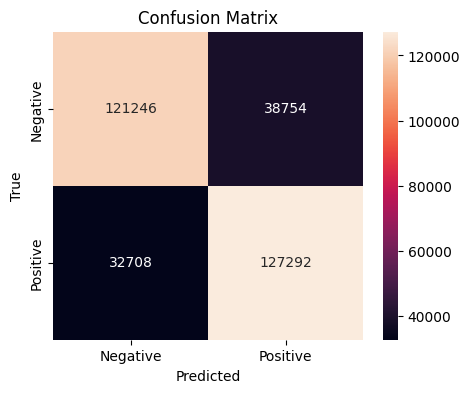

In [ ]:
#confusion Matrix
target_names=['Negative', 'Positive']
cm = confusion_matrix(Y_test, X_test_prediction)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()